# K-Nearest Neighbors Classification with Breast Cancer Data

In [ ]:
from sklearn.datasets import load_breast_cancer
dataset = load_breast_cancer()

## Part 1: Date Exploration and Preparation

- Number of features in this dataset: 30
- Target classes: 0 and 1 ('malignant' and 'benign')
- Number of participants tested `Malignant`: 212
- Number of participants tested `Benign`: 357

In [ ]:
import pandas as pd
import numpy as np
import sklearn

In [ ]:
dt = pd.DataFrame.from_dict(dataset["data"])
dt.columns = dataset["feature_names"]
dt["target"] = dataset["target"]

In [ ]:
dt

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.5950,5.772,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


In [ ]:
## Number of features in the dataset
len(dataset.feature_names)

30

In [ ]:
## Number of "Malignant" and "Benign" cases
malignant = dt[(dt.target == 0)]
len(malignant)
benign = dt[(dt.target == 1)]
len(benign)

357

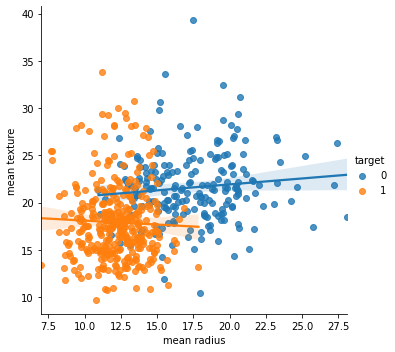

In [ ]:
import seaborn as sns

## First plot
sns.lmplot(x="mean radius", y="mean texture", hue="target", data=dt)

(Note that 0 is malignant, and 1 is benign.)

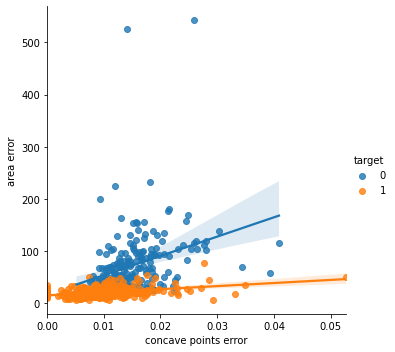

In [ ]:
## Second plot (two features with very different scales)
sns.lmplot(x="concave points error", y="area error", hue="target", data=dt)

(Note that 0 is malignant, and 1 is benign.)

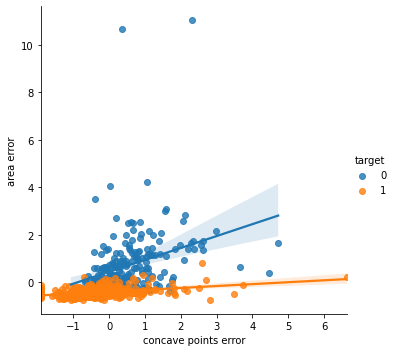

In [ ]:
## Standardization of data and plot again
dt["target"] = dt['target'].astype('category')
dt_copy = dt.copy(deep=True)
pdt = dt_copy.loc[:, dt_copy.columns != 'target']
standardized_dt = (pdt-pdt.mean()) / pdt.std()
standardized_dt['target'] = dt_copy['target']
sns.lmplot(x="concave points error", y="area error", hue="target", data=standardized_dt)

(Note that 0 is malignant, and 1 is benign.)

From the above plot of the standardized features, we can see that both features are now centered around 0 with a standard deviation of 1. The datapoint distributions and patterns remain the same.

### First train test split before using kNN models:

In [ ]:
## Train Test Split
from sklearn.model_selection import train_test_split

X = dt.drop('target', axis=1)
y = dt['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## Part 2: KNN Classifier without Standardization (for comparison)



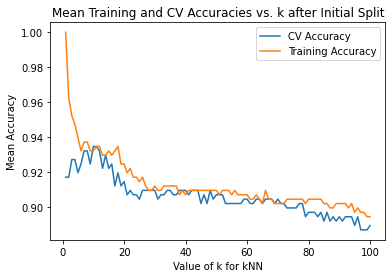

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
%matplotlib inline

## Create helper function for plotting the training accuracy vs. 
## cross-validation accuracy plot with various k values
def k_acc_plot(start: int, end: int, X_t, y_t, method: str):
    ## Set k range and initialize lists
    k_range = range(start, end)
    k_scores = []
    train_acc = []
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_t, y_t)
        accuracy = accuracy_score(y_t, knn.predict(X_t))
        scores = cross_val_score(knn, X_t, y_t, cv=5, scoring='accuracy')
        k_scores.append(scores.mean())
        train_acc.append(accuracy.mean())

    ## Plot mean CV accuracies for k
    plt.title('Mean Training and CV Accuracies vs. k after ' + method)
    plt.plot(k_range, k_scores, label="CV Accuracy")
    plt.plot(k_range, train_acc, label="Training Accuracy")
    plt.legend()
    plt.xlabel('Value of k for kNN')
    plt.ylabel('Mean Accuracy')
    plt.show()

## Plot accuracies vs. k values
k_acc_plot(1, 101, X_train, y_train, "Initial Split")

On the plot, we can see that the training accuracy is way higher than the cross-validation accuracy when k is less than 10, which indicates that this is the area of overfitting where k is too small; such model will lead to poor testing performance. As k increases beyond 10, we can see the massive drop of both accuracies starting around 15-20, indicating the start of underfitting. Underfitting also leads to poor generalizability.

The sweet spot seems to be around k = 10 where there's overlap between the two accuracy curves and the cross-validation accuracy curve is at its apex.

In general, the models are prone to overfit when training accuracy is higher than CV accuracy, and underfit when both accuracies are low.

In [ ]:
## Find best k using GridSearchCV
from sklearn.model_selection import GridSearchCV

## Create a helper function for using GridSearchCV to check results
def gridsearch_check(start: int, end: int, X_t, y_t):
    knn = KNeighborsClassifier()
    param_grid = {'n_neighbors': np.arange(start, end)}
    knn_gscv = GridSearchCV(knn, param_grid, cv=5)
    knn_gscv.fit(X_t, y_t)
    print('Best k: ', knn_gscv.best_params_, ', Best score: ', knn_gscv.best_score_ * 100, "%")

## Run GridSearchCV to check results
gridsearch_check(1, 101, X_train, y_train)

Best k:  {'n_neighbors': 10} , Best score:  93.46518987341771 %


From the mean CV accuracy plot and the GridSearchCV validation of the original dataset, the best k is 10 with a best CV accuracy score of 93.47%.

### Removing Highly-Correlated Features

Before implementing other types of feature selection, I thought it'd be beneficial to first take a look at the correlation between each pair of features. If any of them is identified as highly-correlated, one of the features in that pair would need to be removed.

This is the first attempt of feature reduction, and the results will be compared with the original kNN model as well as the recursive feature elimination method later.

In [ ]:
## Check correlation scores between each pair of features
corr = X.corr()
corr.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
mean radius,1.000000,0.323782,0.997855,0.987357,0.170581,0.506124,0.676764,0.822529,0.147741,-0.311631,0.679090,-0.097317,0.674172,0.735864,-0.222600,0.206000,0.194204,0.376169,-0.104321,-0.042641,0.969539,0.297008,0.965137,0.941082,0.119616,0.413463,0.526911,0.744214,0.163953,0.007066
mean texture,0.323782,1.000000,0.329533,0.321086,-0.023389,0.236702,0.302418,0.293464,0.071401,-0.076437,0.275869,0.386358,0.281673,0.259845,0.006614,0.191975,0.143293,0.163851,0.009127,0.054458,0.352573,0.912045,0.358040,0.343546,0.077503,0.277830,0.301025,0.295316,0.105008,0.119205
mean perimeter,0.997855,0.329533,1.000000,0.986507,0.207278,0.556936,0.716136,0.850977,0.183027,-0.261477,0.691765,-0.086761,0.693135,0.744983,-0.202694,0.250744,0.228082,0.407217,-0.081629,-0.005523,0.969476,0.303038,0.970387,0.941550,0.150549,0.455774,0.563879,0.771241,0.189115,0.051019
mean area,0.987357,0.321086,0.986507,1.000000,0.177028,0.498502,0.685983,0.823269,0.151293,-0.283110,0.732562,-0.066280,0.726628,0.800086,-0.166777,0.212583,0.207660,0.372320,-0.072497,-0.019887,0.962746,0.287489,0.959120,0.959213,0.123523,0.390410,0.512606,0.722017,0.143570,0.003738
mean smoothness,0.170581,-0.023389,0.207278,0.177028,1.000000,0.659123,0.521984,0.553695,0.557775,0.584792,0.301467,0.068406,0.296092,0.246552,0.332375,0.318943,0.248396,0.380676,0.200774,0.283607,0.213120,0.036072,0.238853,0.206718,0.805324,0.472468,0.434926,0.503053,0.394309,0.499316


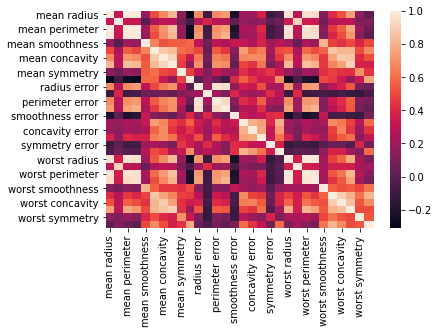

In [ ]:
## Correlation heatmap
sns.heatmap(corr)

In [ ]:
## Removing one feature in every pair with correlation >= 0.9
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False

## Set up remaining data
X_corr = X.copy(deep=True)
selected_columns = X_corr.columns[columns]
X_corr = X_corr[selected_columns]
X_corr.shape

(569, 20)

After removing one feature in every pair of features with a correlation score that's larger than or equal to 0.90, 20 features remain.

### kNN CV using resulting data

Using the X data with 20 features, here is the train test split again before further cross validation testing.

In [ ]:
## Train test split again
X_trainc, X_testc, y_trainc, y_testc = train_test_split(X_corr, y, test_size=0.3, random_state=0)

For this part the cross validation process and GridSearchCV are employed to check the CV training accuracy after removing highly-correlated features.

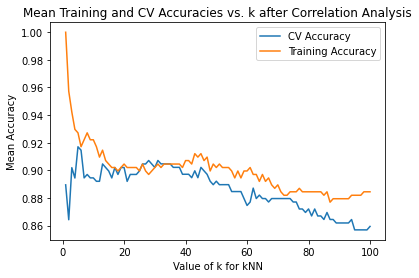

In [ ]:
## Plot accuracies vs. k values
k_acc_plot(1, 101, X_trainc, y_trainc, "Correlation Analysis")

In [ ]:
## Run GridSearchCV to check results
gridsearch_check(1, 101, X_trainc, y_trainc)

Best k:  {'n_neighbors': 5} , Best score:  91.70253164556964 %


Using the dataset with just the hightly-correlated features removed, we see a drop in accuracy. The best k becomes 5 and the accuracy becomes 91.70%.

This might be because of the fact that even though some of the features are correlated, they still contain valuable information about the predicted class. Correlated features do not necessarily affect classification accuracy, but removing them does lead to a lower accuracy. A better way to approach this might be PCA.

### Feature Selection Using RFECV

For the backward elimination option I decided to use the Recursive Feature Elimination with Cross-Validation (RFECV). RFECV uses random forest model for feature importance and CV to ensure the best selection of features. This should be a safe way of feature elimination without lossing too much information.

Recursive Feature Elimination starts by fitting a random forest classifier model on the entire set of features against the target data and computing an importance score for each predictor. The weakest features are then removed, the model is re-fitted, and importance scores are computed again until it reaches the specified number of features. However, since we do not know in advance how many features are valid, we use the RFECV which combines RFE with cross-validation to score different feature subsets and select the best scoring collection of features. This way I hope to find the optimal number of features to use.

Optimal number of features : 18
Best features : ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean concavity', 'mean concave points', 'radius error', 'perimeter error', 'area error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry']


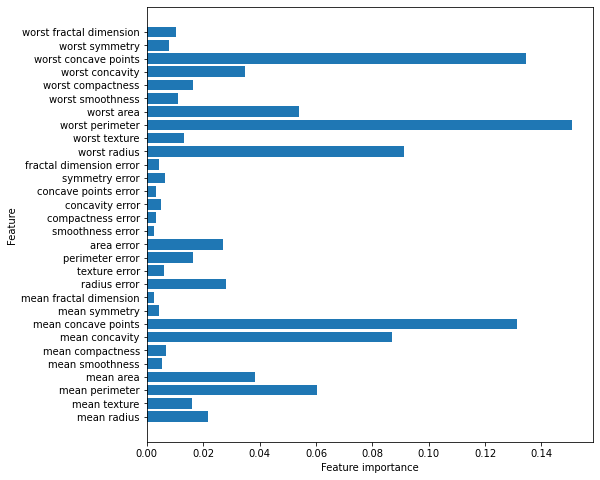

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

## Build RFECV using the original training dataset
cv_estimator = RandomForestClassifier(random_state=0)
cv_estimator.fit(X_train, y_train)
cv_selector = RFECV(cv_estimator,cv= 10, step=1,scoring='accuracy')
cv_selector = cv_selector.fit(X_train, y_train)
rfecv_mask = cv_selector.get_support()

## Append the appropriate features into a list
rfecv_features = []

for bool, feature in zip(rfecv_mask, X_train.columns):
    if bool:
        rfecv_features.append(feature)

## Plot the remaining features with their importance
print('Optimal number of features :', cv_selector.n_features_)
print('Best features :', rfecv_features)
n_features = X_train.shape[1]
plt.figure(figsize=(8,8))
plt.barh(range(n_features), cv_estimator.feature_importances_, align='center') 
plt.yticks(np.arange(n_features), X_train.columns.values) 
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

### Update train-test split and kNN again

Next we use the resulting features from the RFECV elimination process to extract the most relevant feature data, and re-do the train test split before fitting the kNN again.

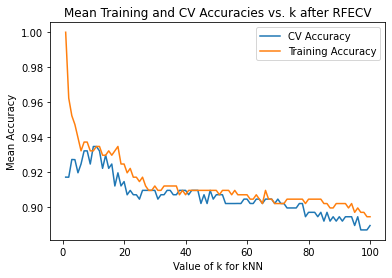

In [ ]:
## Re-train kNN Model
X2 = dt.loc[:, rfecv_features]
y = dt['target']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, test_size=0.3, random_state=0)

## Plot accuracies vs. k values
k_acc_plot(1, 101, X_train2, y_train2, "RFECV")

In [ ]:
## Run GridSearchCV to check results
gridsearch_check(1, 101, X_train2, y_train2)

Best k:  {'n_neighbors': 10} , Best score:  93.46518987341771 %


After feature reduction, the best k is 10 with a best mean accuracy of 93.47%, which is the same as the original results from the kNN model using the complete dataset.

With the 18 remaining features, this kNN model still achieves the same accuracy as the original one while maintaining the same best k (10). This indicates that the removed features indeed do not contribute too much to the prediction of cancer diagnosis in this case.

From the above results, we can conclude that the RFECV approach is better than simply removing highly-correlated features in this case. Removing highly-correlated features lead to a lower CV training accuracy score while the RFECV results prove that it can still get the same CV accuracy scores as the original dataset with less features.

If we remove even more features, we will start to see a lower mean accuracy score across the range of k values compared to before. This might indicate that this remaining dataset has nice distributions across features, and removing some of them reduces the information within.

## Part 3: KNN Classifier with Standardization


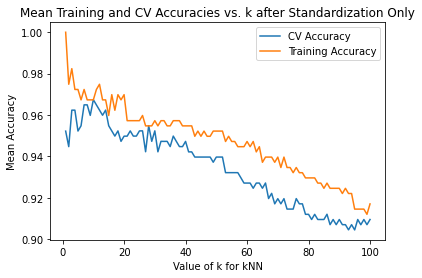

In [ ]:
## Standardize data
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

sc = StandardScaler()
X_train3 = sc.fit_transform(X_train)
X_train3_df = pd.DataFrame(X_train3, index=X_train.index, columns=X_train.columns)
X_test3 = sc.transform(X_test)

## Plot accuracies vs. k values
k_acc_plot(1, 101, X_train3_df, y_train, "Standardization Only")

After Standardization alone, the best k remains to be 10 while the CV accuracy plot has a higher apex and a slightly different slope than the one in part 2.

In [ ]:
## Run GridSearchCV to check results
gridsearch_check(1, 101, X_train3_df, y_train)

Best k:  {'n_neighbors': 10} , Best score:  96.74367088607593 %


We can see that with standardization, the CV accuracy has increased to 96.74%.

The same RFECV process is implemented below as an attempt to further improve our model. We want to see if removing some features with least importance scores would lead to a better outcome.

Optimal number of features : 18
Best features : ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean concavity', 'mean concave points', 'radius error', 'perimeter error', 'area error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry']


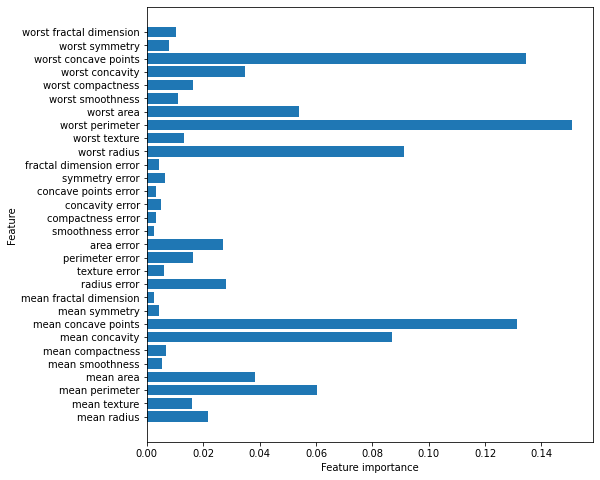

In [ ]:
## RFECV for feature elimination
cv_estimator2 = RandomForestClassifier(n_jobs=4, random_state=0)
cv_estimator2.fit(X_train3_df, y_train)
cv_selector2 = RFECV(cv_estimator2,cv= 10, step=1,scoring='accuracy')
cv_selector2 = cv_selector2.fit(X_train3_df, y_train)
rfecv_mask2 = cv_selector2.get_support()

rfecv_features2 = []

for bool, feature in zip(rfecv_mask2, X_train3_df.columns):
    if bool:
        rfecv_features2.append(feature)

print('Optimal number of features :', cv_selector2.n_features_)
print('Best features :', rfecv_features2)
n_features2 = X_train3_df.shape[1]
plt.figure(figsize=(8,8))
plt.barh(range(n_features2), cv_estimator2.feature_importances_, align='center') 
plt.yticks(np.arange(n_features2), X_train3_df.columns.values) 
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

In [ ]:
## Re-train kNN Model
X4_be = dt.loc[:, rfecv_features2]
y4 = dt['target']

X_train4, X_test4, y_train4, y_test4 = train_test_split(X4_be, y4, test_size=0.3, random_state=0)

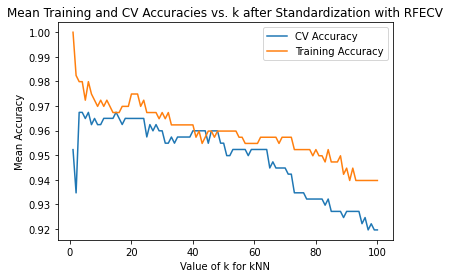

In [ ]:
## Standardization
sc = StandardScaler()
X_train4_be = sc.fit_transform(X_train4)
X_train4_df = pd.DataFrame(X_train4_be, index=X_train4.index, columns=X_train4.columns)
X_test4 = sc.transform(X_test4)

## Plot accuracies vs. k values
k_acc_plot(1, 101, X_train4_df, y_train4, "Standardization with RFECV")

In [ ]:
## Run GridSearchCV to check results
gridsearch_check(1, 101, X_train4_df, y_train4)

Best k:  {'n_neighbors': 15} , Best score:  96.74683544303797 %


With standardization and recursive feature elimination, this last model gives us slightly improved accuracy from cross validation and a best k of 15.

Standardization does lead to better model performance. We can see that after standardization, the best scores of the kNN models both before and after feature reduction are better than those of the models without standardization in Part 2.

The best model so far is the kNN model with standardization and recursive feature elimination. The mean CV accuracy score is 96.75% with a k value of 15.

## Part 4: Testing

In [ ]:
from sklearn import metrics

#Create 15-NN Classifier (k=15 from end of part 3)
knn4 = KNeighborsClassifier(n_neighbors=15)

#Train the model using the training sets
knn4.fit(X_train4_df, y_train4)

#Predict the response for test dataset
y_pred = knn4.predict(X_test4)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred)* 100, "%")


Accuracy: 95.90643274853801 %


Using the standardized X_train, X_test, and the original y_test set from before, the 15-NN model produces a pretty decent accuracy of 95.91%.

## Part 5: KNN Classifier with a New Dataset

### Wine Recognition Dataset

For this part of the project I decided to use the Wine Recognition Dataset from the Scikit-Learn libraries. This dataset is originally from the UCI Machine Learning directory, and is the results of a chemical analysis of wines grown in the same region in Italy by three different cultivators. There are thirteen different measurements taken for different constituents found in the three types of wine.

There are 178 observations and 13 numeric attributes/features. The target variable is 0/1/2, which are the three classes of wine for classification. I will explore these characteristics further below.

Original Owners:

Forina, M. et al, PARVUS - An Extendible Package for Data Exploration, Classification and Correlation. Institute of Pharmaceutical and Food Analysis and Technologies, Via Brigata Salerno, 16147 Genoa, Italy.

Citation:

Lichman, M. (2013). UCI Machine Learning Repository [https://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

In [ ]:
## Load necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
from sklearn import datasets

#Load wine dataset and transform into Pandas DataFrame
wine = datasets.load_wine()
df = pd.DataFrame.from_dict(wine["data"])
df.columns = wine["feature_names"]
df["target"] = wine["target"]

### Exploratory Data Analysis

In [ ]:
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [ ]:
df.shape

(178, 14)

In [ ]:
df.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000


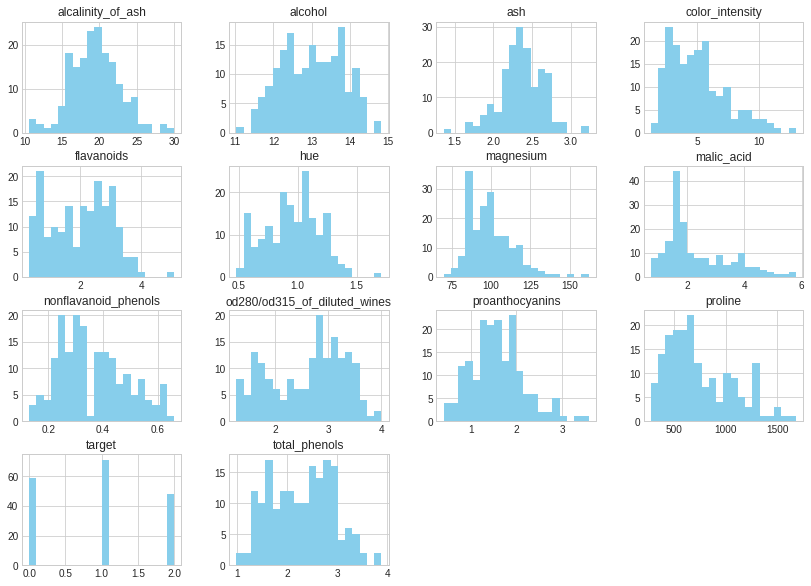

In [ ]:
## Feature plots
plt.style.use('seaborn-whitegrid')
df.hist(bins=20, figsize=(14, 10), color='skyblue')
plt.show()

In [ ]:
dataTypeSeries = df.dtypes
print('Data type of each column of Dataframe :')
print(dataTypeSeries)

Data type of each column of Dataframe :
alcohol                         float64
malic_acid                      float64
ash                             float64
alcalinity_of_ash               float64
magnesium                       float64
total_phenols                   float64
flavanoids                      float64
nonflavanoid_phenols            float64
proanthocyanins                 float64
color_intensity                 float64
hue                             float64
od280/od315_of_diluted_wines    float64
proline                         float64
target                            int64
dtype: object


This table confirms that all attributes are numeric.

In [ ]:
df.isna().sum()

alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
target                          0
dtype: int64

In [ ]:
df["target"].value_counts()

1    71
0    59
2    48
Name: target, dtype: int64

This dataset's target distribution is: class_0 = 59, class_1 = 71, class_2 = 48.

### Train test split (70/30) and further modeling

In [ ]:
## Train Test Split using 70/30 ratio and random state = 0
X = df.drop(columns=['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [ ]:
## Standardization
sc = StandardScaler()
X_train_wine = sc.fit_transform(X_train)
X_train = pd.DataFrame(X_train_wine, index=X_train.index, columns=X_train.columns)
X_test = sc.transform(X_test)

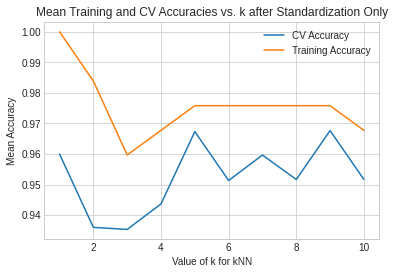

In [ ]:
## Set k range between 1 and 11 since k should be less then sprt(n)
## Plot accuracies vs. k values
k_acc_plot(1, 11, X_train, y_train, "Standardization Only")

In [ ]:
## Run GridSearchCV to check results
gridsearch_check(1, 11, X_train, y_train)

Best k:  {'n_neighbors': 9} , Best score:  96.76666666666665 %


From both the mean CV accuracy plot and GridSearchCV results, the best k is 9 and the mean CV accuracy is 96.77%.

Optimal number of features : 11
Best features : ['alcohol', 'malic_acid', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']


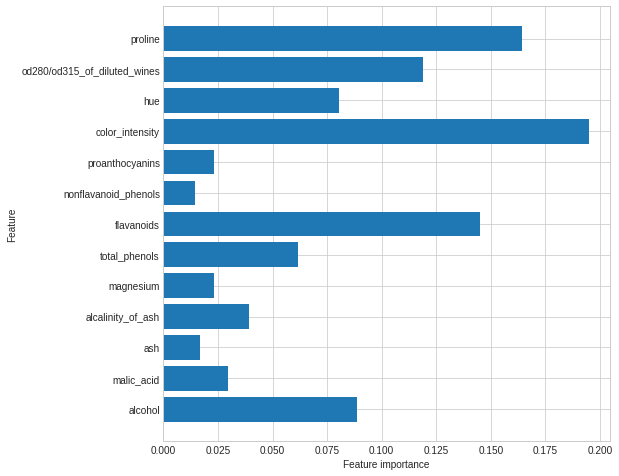

In [ ]:
## RFECV for feature elimination
cv_estimator5 = RandomForestClassifier(n_jobs=4, random_state=0)
cv_estimator5.fit(X_train, y_train)
cv_selector5 = RFECV(cv_estimator5, cv=10, step=1,scoring='accuracy')
cv_selector5 = cv_selector5.fit(X_train, y_train)
rfecv_mask5 = cv_selector5.get_support()

rfecv_features5 = []

for bool, feature in zip(rfecv_mask5, X_train.columns):
    if bool:
        rfecv_features5.append(feature)

print('Optimal number of features :', cv_selector5.n_features_)
print('Best features :', rfecv_features5)
n_features5 = X_train.shape[1]
plt.figure(figsize=(8,8))
plt.barh(range(n_features5), cv_estimator5.feature_importances_, align='center') 
plt.yticks(np.arange(n_features5), X_train.columns.values) 
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

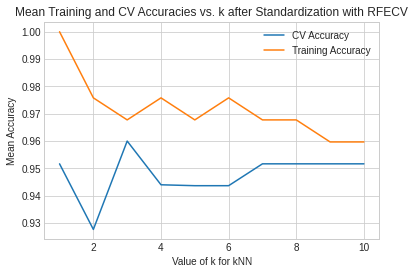

In [ ]:
## Re-train kNN Model
X5_be = df.loc[:, rfecv_features5]
y5 = df['target']

X_train5, X_test5, y_train5, y_test5 = train_test_split(X5_be, y5, test_size=0.3, random_state=0)

## Standardization
sc = StandardScaler()
X_train5_be = sc.fit_transform(X_train5)
X_train5_df = pd.DataFrame(X_train5_be, index=X_train5.index, columns=X_train5.columns)
X_test5 = sc.transform(X_test5)

## Plot accuracies vs. k values
k_acc_plot(1, 11, X_train5_df, y_train5, "Standardization with RFECV")

In [ ]:
## Run GridSearchCV to check results
gridsearch_check(1, 11, X_train5_df, y_train5)

Best k:  {'n_neighbors': 3} , Best score:  96.0 %


Here we can see that recursive feature elimination brings down the CV accuracy slightly by 0.77%. This could be explained by the fact that this wine dataset only has 13 features, and removing even just two of them leads to information loss.

Thus we will use the kNN model before feature elimination for testing because it has the higher training CV accuracy and it retains information from the original dataset.

In [ ]:
## Testing the kNN model
knn_test = KNeighborsClassifier(n_neighbors=9)

#Train the model using the training sets
knn_test.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = knn_test.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 1.0


In [ ]:
X_test.shape

(54, 13)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        22
           2       1.00      1.00      1.00        13

    accuracy                           1.00        54
   macro avg       1.00      1.00      1.00        54
weighted avg       1.00      1.00      1.00        54



With a k of 9, the testing accuracy is 1. However, this is a very limited result due to the following reasons:

Since the original win recognition dataset only has 178 observations and 13 features, the test data only contains 54 testing observations. From the above classification report, we can see that there are not enough "support" cases for each category (19 for "0", 22 for "1", 13 for "2").

The very small size of the test set does not help with the evaluation of the kNN model. Even though the testing above shows an accuracy of 1, this does not prove that the model is generalizable. For further evaluation, we'd need to feed more samples into both the training and the testing sets to get better results.

Although the result is suboptimal, the above workflow / steps can be implemented using another dataset with more instances.